In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy
import sys
import os
from time import time
np.random.seed(1234567)

sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil

from datainterface import patient as Pat

# dimensionality reductions
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    f1_score

from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# define the data handler 
sys.path.append('../')
import processing.util as util

from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

import fragility.linearmodels.fragilitymodels

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
datadir = '/Volumes/ADAM LI/pydata/dnn/traindata/tenpercentcorrupted/fft/'
datadir = '/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/'

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
        
print(len(datafiles))

datahandler = util.DataHandler()

numcomp = 50
# PCA
sklearn_pca = PCA(n_components=numcomp)

print(datadir)
print(os.getcwd())

0
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/seegpert/
/Users/adam2392/Documents/dnn-unsupervised/dnn/baseline analysis


In [8]:
winsize = 250
stepsize = 125
radius = 1.5
perturbtype = 'C'

# postprocessor = tvbsim.util.PostProcess([], [], [])
fragilitymodel = fragility.linearmodels.fragilitymodels.FragilityModel(winsize, stepsize, radius, perturbtype)


INFO:fragility.linearmodels.fragilitymodels:Initialized perturbation model!
INFO:fragility.linearmodels.fragilitymodels:Initialized fragility model!


# 0 Load in Actual SEEG Dataset And Run Algorithm Cells

Load in an actual real EEG dataset and then run analysis with baseline classifiers

In [15]:
patient = 'id001_ac_sz2'
patient = 'id013_pg_sz1'
datadir = '/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/' + patient

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
        
print(len(datafiles))

datahandler = util.DataHandler()

numcomp = 50
# PCA
sklearn_pca = PCA(n_components=numcomp)

print("testing datadir is: ", datadir)

1
testing datadir is:  /Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id013_pg_sz1


# 1 Load Data and Concatenate 

Assumes, we can't make use of the time dimension. We apply PCA on the frequency feature space, expecting n_components to capture sufficient variability in the data to match the variability that will be seen by the deep neural networks.

- Load data
- PCA (n_components)
- split training/testing data

In [16]:
patient = 'id001_ac_sz2'
patid = patient[0:patient.find('sz')-1]
seizid = patient[patient.find('sz'):]

datadir = '/Volumes/ADAM LI/pydata/convertedtng'

chanfile =  os.path.join(datadir,  patient, patid + '_chans.csv')
headerfile = os.path.join(datadir,  patient, patid + '_headers.csv')
annotationsfile = os.path.join(datadir,  patient, patid + '_annotations.csv')

################################ 1. LOAD DATA ###########################
# instantiate a datainterface object to analyze data
patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
# get relevant channel data
included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)

# set metadata to be used in analysis
patieeg.setincludedchans(included_chans)
patieeg.setmetadata_fromfile(headersfile=headerfile)
patieeg.setchannels_fromfile(channelsfile=chanfile)
patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


In [19]:
# print(patieeg.onset_time, patieeg.offset_time)
# print(timepoints.shape)
# print(timepoints[0:3,:])

# fragmat = fragmat[:,1:]
# timepoints = timepoints[1:,:]

print(fragmat.shape)
print(timepoints.shape)


(59, 2468)
(2468, 2)


In [20]:
# load datafiles into features
for idx, datafile in enumerate(datafiles):
    print(datafile)
    # load data
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    pertmats = data['pertmats']
    timepoints = data['timepoints']
    fragmat = fragilitymodel.compute_fragilitymetric(pertmats)
    
    # compute ylabels
    seizonsets = np.multiply([patieeg.onset_time], 500)
    seizoffsets = np.multiply([patieeg.offset_time], 500)
    ylabels = datahandler.computelabels(seizonsets, seizoffsets, timepoints)

    if idx == 0:
        Xdata = fragmat.T
        ydata = ylabels
    else:
        Xdata = np.concatenate((Xdata, fragmat.T), axis=0)
        ydata = np.concatenate((ydata,ylabels), axis=0)
        
print(Xdata.shape)
print(ydata.shape) 

/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id013_pg_sz1/id013_pg_sz1pertmodel.npz


/Users/adam2392/Documents/fragility_analysis/fragility/linearmodels/fragilitymodels.py:426: RuntimeWarning: invalid value encountered in true_divide
  np.max(minnormpertmat[:, icol])


IndexError: index 0 is out of bounds for axis 0 with size 0

id001_ac_sz2
id001_ac_sz2
/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id013_pg_sz1/id013_pg_sz1pertmodel.npz
dict_keys([b'onset_time', b'offset_time', b'chanlabels'])
[b'A1' b'A2' b'A3' b'A4' b'A5' b'A6' b'B1' b'B2' b'B3' b'B4' b'B5' b'B6'
 b'B7' b'B8' b'B9' b'B10' b'B11' b'TB1' b'TB2' b'TB3' b'TB4' b'TB5' b'TB6'
 b'TB7' b'TB8' b'TB9' b'C1' b'C2' b'C3' b'C4' b'C5' b'C6' b'OT1' b'OT2'
 b'OT3' b'OT4' b'OT5' b'OT6' b'OT7' b'OT8' b'OT9' b'OP1' b'OP2' b'OP3'
 b'OP4' b'OP5' b'OP6' b'OP7' b'OP8' b'OP9' b'PI1' b'PI2' b'PI3' b'PI4'
 b'PI5' b'PI6' b'PI7' b'PI8' b'PI9']


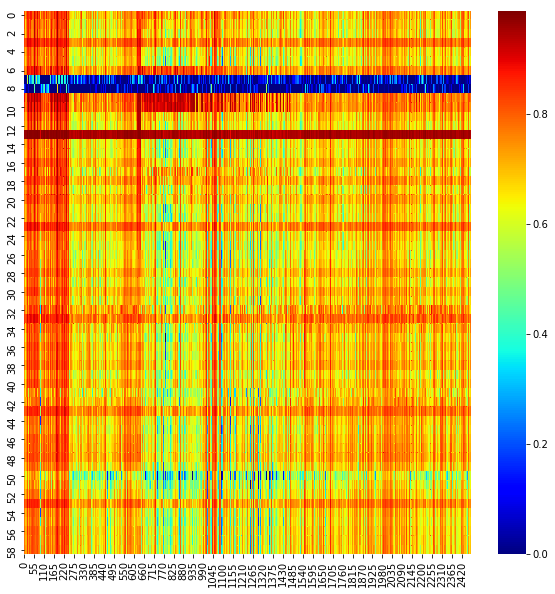

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(fragmat, cmap='jet')
print(patient)
print(patieeg.patient)
print(datafile)
print(metadata.keys())
print(metadata[b'chanlabels'])

In [33]:
randstate = 42 # for reproducability
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.33, random_state=randstate)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38565, 70)
(18995, 70)
(38565, 1)
(18995, 1)


# 1. Run RF and LR

These cells are going to run the linear classifiers on purely the training and testing data

In [49]:
datadir = '/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id001_ac_sz2'

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
        
print(len(datafiles))

datahandler = util.DataHandler()

numcomp = 50
# PCA
sklearn_pca = PCA(n_components=numcomp)

print("testing datadir is: ", datadir)

1
testing datadir is:  /Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id001_ac_sz2


In [50]:
patient = 'id001_ac_sz2'
patid = patient[0:patient.find('sz')-1]
seizid = patient[patient.find('sz'):]

datadir = '/Volumes/ADAM LI/pydata/convertedtng'

chanfile =  os.path.join(datadir,  patient, patid + '_chans.csv')
headerfile = os.path.join(datadir,  patient, patid + '_headers.csv')
annotationsfile = os.path.join(datadir,  patient, patid + '_annotations.csv')

################################ 1. LOAD DATA ###########################
# instantiate a datainterface object to analyze data
patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
# get relevant channel data
included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)

# set metadata to be used in analysis
patieeg.setincludedchans(included_chans)
patieeg.setmetadata_fromfile(headersfile=headerfile)
patieeg.setchannels_fromfile(channelsfile=chanfile)
patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


In [58]:
# load datafiles into features
for idx, datafile in enumerate(datafiles):
    print(datafile)
    # load data
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    pertmats = data['pertmats']
    timepoints = data['timepoints']
    fragmat = fragilitymodel.compute_fragilitymetric(pertmats)
    
    # compute ylabels
    seizonsets = np.multiply([patieeg.onset_time], 500)
    seizoffsets = np.multiply([patieeg.offset_time], 500)
    ylabels = datahandler.computelabels(seizonsets, seizoffsets, timepoints)

    if idx == 0:
        Xdata = fragmat.T
        ydata = ylabels
    else:
        Xdata = np.concatenate((Xdata, fragmat.T), axis=0)
        ydata = np.concatenate((ydata,ylabels), axis=0)
        
print(Xdata.shape)
print(ydata.shape) 

/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/id001_ac_sz2/id001_ac_sz2pertmodel.npz
(4945, 70)
(4945, 1)


/Users/adam2392/Documents/fragility_analysis/fragility/linearmodels/fragilitymodels.py:426: RuntimeWarning: invalid value encountered in true_divide
  np.max(minnormpertmat[:, icol])


In [59]:
# get rid of first column of nans
Xdata = Xdata[1:, :]
ydata = ydata[1:]
print(Xdata.shape)
print(np.where(np.isnan(Xdata)))

(4944, 70)
(array([], dtype=int64), array([], dtype=int64))


Out-of-bag score estimate: 0.828
Mean accuracy score: 0.433
F1 score: 0.08963949334199416
Recall: 0.047406389556853314
Precision: 0.8214285714285714

 clasification report:
              precision    recall  f1-score   support

        0.0       0.42      0.99      0.59      2033
        1.0       0.82      0.05      0.09      2911

avg / total       0.66      0.43      0.29      4944


 confusion matrix:
 [[2003   30]
 [2773  138]]


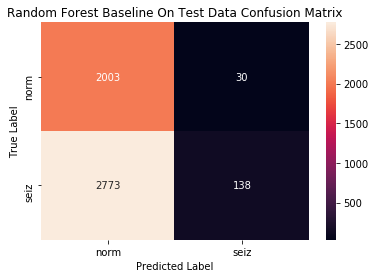

Out-of-bag score estimate: 0.828
Mean accuracy score: 0.539
F1 score: 0.6425098039215688
Recall: 0.7035383029886637
Precision: 0.5912240184757506

 clasification report:
              precision    recall  f1-score   support

        0.0       0.42      0.30      0.35      2033
        1.0       0.59      0.70      0.64      2911

avg / total       0.52      0.54      0.52      4944


 confusion matrix:
 [[ 617 1416]
 [ 863 2048]]


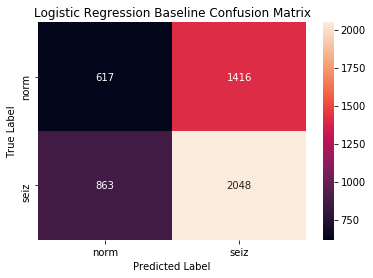

In [60]:
rf_test = rf.predict(Xdata)
ytrue = ydata
print('Out-of-bag score estimate: %.3f' % rf.oob_score_)
print('Mean accuracy score: %.3f' % accuracy_score(ytrue, rf_test))
print('F1 score:', f1_score(ytrue, rf_test))
print('Recall:', recall_score(ytrue, rf_test))
print('Precision:', precision_score(ytrue, rf_test))
print('\n clasification report:\n', classification_report(ytrue, rf_test))
print('\n confusion matrix:\n',confusion_matrix(ytrue, rf_test))

fig = plt.figure()
cm = pd.DataFrame(confusion_matrix(ytrue, rf_test), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True, fmt='g')
ax = plt.gca()
ax.set_title('Random Forest Baseline On Test Data Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

lr_test = estimator.predict(Xdata)
ytrue = ydata

print('Out-of-bag score estimate: %.3f' % rf.oob_score_)
print('Mean accuracy score: %.3f' % accuracy_score(ytrue, lr_test))
print('F1 score:', f1_score(ytrue, lr_test))
print('Recall:', recall_score(ytrue, lr_test))
print('Precision:', precision_score(ytrue, lr_test))
print('\n clasification report:\n', classification_report(ytrue, lr_test))
print('\n confusion matrix:\n',confusion_matrix(ytrue, lr_test))

fig = plt.figure()
cm = pd.DataFrame(confusion_matrix(ytrue, lr_test), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True, fmt='g')
ax = plt.gca()
ax.set_title('Logistic Regression Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

Baseline testing prediction of all seizure:  0.588794498381877


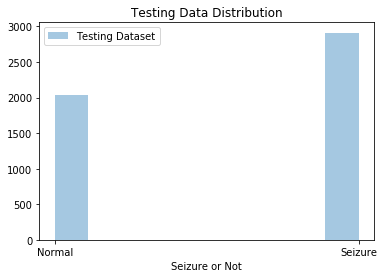

In [62]:
plt.figure()
sns.distplot(ydata, kde=False, axlabel='Seizure or Not', label='Testing Dataset')
ax=plt.gca()
ax.set_title('Testing Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

print("Baseline testing prediction of all seizure: ", np.sum(ydata)/len(ydata))

# 1. Run RF and LR

These cells are going to run the linear classifiers on purely the training and testing data

In [35]:
%%time
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=randstate)
res = rf.fit(X_train, y_train.ravel())
print(res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
CPU times: user 29.1 s, sys: 188 ms, total: 29.2 s
Wall time: 29.4 s


Out-of-bag score estimate: 0.828
Mean accuracy score: 0.835
F1 score: 0.88678088367899
Recall: 0.9429316560558411
Precision: 0.8369417211328976

 clasification report:
              precision    recall  f1-score   support

        0.0       0.83      0.60      0.69      5958
        1.0       0.84      0.94      0.89     13037

avg / total       0.83      0.83      0.83     18995


 confusion matrix:
 [[ 3563  2395]
 [  744 12293]]


Text(0.5,15,'Predicted Label')

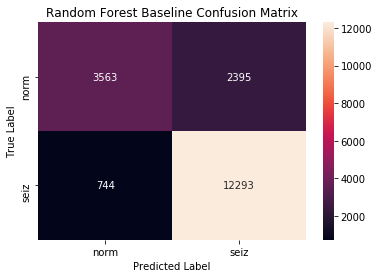

In [36]:
predicted = rf.predict(X_test)

print('Out-of-bag score estimate: %.3f' % rf.oob_score_)
print('Mean accuracy score: %.3f' % accuracy_score(y_test, predicted))
print('F1 score:', f1_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('\n clasification report:\n', classification_report(y_test,predicted))
print('\n confusion matrix:\n',confusion_matrix(y_test, predicted))

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True, fmt='g')
ax = plt.gca()
ax.set_title('Random Forest Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

In [37]:
%%time
logistic = linear_model.LogisticRegression()
scaler = StandardScaler()
# set pipeline to run things using sklearn
pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logistic)])

# Prediction
Cs = np.logspace(-4, 4, 3)
penalty = ['l1', 'l2']
max_iter = [100, 1000, 2000]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(logistic__penalty=penalty,
                              logistic__C=Cs,
                              logistic__max_iter=max_iter
                             ))
result = estimator.fit(X_train, y_train.ravel())
print(result)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic__penalty': ['l1', 'l2'], 'logistic__C': array([1.e-04, 1.e+00, 1.e+04]), 'logistic__max_iter': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
CPU times: user 2min 3s, sys: 1.85 s, total: 2min 5s
Wall time: 2min 5s


Mean accuracy score: 0.800
F1 score: 0.862193884944211
Recall: 0.9127866840530797
Precision: 0.8169149447381067

 clasification report:
              precision    recall  f1-score   support

       norm       0.74      0.55      0.63      5958
      onset       0.82      0.91      0.86     13037

avg / total       0.79      0.80      0.79     18995


 confusion matrix:
 [[ 3291  2667]
 [ 1137 11900]]


Text(0.5,15,'Predicted Label')

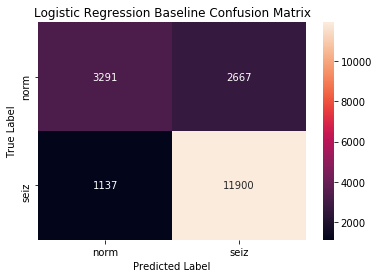

In [38]:
predicted = estimator.predict(X_test)
y_true = y_test

print('Mean accuracy score: %.3f' % accuracy_score(y_test, predicted))
print('F1 score:', f1_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('\n clasification report:\n', classification_report(y_test,predicted, target_names=['norm', 'onset']))
print('\n confusion matrix:\n',confusion_matrix(y_test, predicted))

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True, fmt='g')
ax = plt.gca()
ax.set_title('Logistic Regression Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')